# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
#pip install scipy==1.1.0

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached scipy-1.1.0-cp38-cp38-linux_x86_64.whl
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.19.2 requires scipy>=1.4.1, but you have scipy 1.1.0 which is incompatible.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)
#tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

# Deep Learning Course Project - Gesture Recognition

### Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

Gesture	Corresponding Action
Thumbs Up	Increase the volume.
Thumbs Down	Decrease the volume.
Left Swipe	'Jump' backwards 10 seconds.
Right Swipe	'Jump' forward 10 seconds.
Stop	Pause the movie.

Objectives:
Generator: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

In [4]:
## Checking the GPU configuration

!nvidia-smi

Sun May 15 10:06:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:41:00.0 Off |                  Off |
| 33%   28C    P8    11W / 260W |      5MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Batch size 20, image 120X 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
train_doc = np.random.permutation(open('datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('datasets/Project_data/val.csv').readlines())


In [6]:
batch_size = 20 #experiment with the batch size
x = 30
y = 120
z = 120

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    
                    resized_image = imresize(image,(y,z))
                    resized_image = resized_image/255
                         
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = imresize(image,(y,z))
                    resized_image = resized_image/255
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = 'datasets/Project_data/train'
val_path = 'datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 35 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 35


## Model 1: 3D Conv SGD Optimizer
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
#Updation in Generator as well
x = 15  #Updation in Generator as well
y = 64
z = 64 

#Input layer
model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

#Hidden Layer
model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same',activation='relu'))
model.add(BatchNormalization())

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

#Dense and output layer.
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

2022-05-15 10:06:55.948274: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-15 10:06:55.948366: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22846 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:41:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [9]:

optimiser =  optimizers.SGD(learning_rate=0.01, decay=1e-5, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 64, 64, 64)    5248      
                                                                 
 batch_normalization (BatchN  (None, 15, 64, 64, 64)   256       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 7, 32, 32, 64)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 32, 32, 128)    221312    
                                                                 
 batch_normalization_1 (Batc  (None, 7, 32, 32, 128)   512       
 hNormalization)                                                 
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [11]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
# LR=ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_375/385748685.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_375/1229740096.py:18: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
/tmp/ipykernel_375/1229740096.py:22: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  resized_image = imresize(image,(y,z))


Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/35


2022-05-15 10:07:06.174415: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


33/34 [============================>.] - ETA: 0s - loss: 8.0406 - categorical_accuracy: 0.2682

/tmp/ipykernel_375/1229740096.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
/tmp/ipykernel_375/1229740096.py:49: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  resized_image = imresize(image,(y,z))


34/34 [==============================] - ETA: 0s - loss: 8.0155 - categorical_accuracy: 0.2670Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 66.24117, saving model to model_init_2022-05-1510_06_54.685625/model-00001-8.01551-0.26697-66.24117-0.18000.h5
34/34 [==============================] - 41s 1s/step - loss: 8.0155 - categorical_accuracy: 0.2670 - val_loss: 66.2412 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/35
34/34 [==============================] - ETA: 0s - loss: 14.4410 - categorical_accuracy: 0.2843
Epoch 00002: val_loss did not improve from 66.24117
34/34 [==============================] - 12s 350ms/step - loss: 14.4410 - categorical_accuracy: 0.2843 - val_loss: 80.9734 - val_categorical_accuracy: 0.1600 - lr: 0.0100
Epoch 3/35
34/34 [==============================] - ETA: 0s - loss: 8.7770 - categorical_accuracy: 0.2549
Epoch 00003: val_loss improved from 66.24117 to 17.91578, saving model to model_init_2022

## Model 2: 3D Conv - Adam optimizer epoch 25 batch size 20

In [14]:
# Let us experiment different x,y,z value in the CNN network and find tune all the image size & Hyperparameters later

x = 30 # number of frames
y = 120 # image width
z = 120 # image height

# Input all the images sequencial by building the layer with dropouts and batchnormalisation

model_Three = Sequential()       
model_Three.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(x,y,z,3),padding='same'))
model_Three.add(BatchNormalization())
model_Three.add(Activation('relu'))

model_Three.add(Conv3D(16, (3, 3, 3), padding='same'))
model_Three.add(Activation('relu'))
model_Three.add(BatchNormalization())
model_Three.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_Three.add(Conv3D(32, (2, 2, 2), padding='same'))
model_Three.add(Activation('relu'))
model_Three.add(BatchNormalization())
model_Three.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_Three.add(Conv3D(64, (2, 2, 2), padding='same'))
model_Three.add(Activation('relu'))
model_Three.add(BatchNormalization())
model_Three.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_Three.add(Conv3D(128, (2, 2, 2), padding='same'))
model_Three.add(Activation('relu'))
model_Three.add(BatchNormalization())
model_Three.add(MaxPooling3D(pool_size=(2, 2, 2)))      

# Flatten layer 

model_Three.add(Flatten())

model_Three.add(Dense(1000, activation='relu'))
model_Three.add(Dropout(0.5))

model_Three.add(Dense(500, activation='relu'))
model_Three.add(Dropout(0.55))

#Softmax layer

model_Three.add(Dense(5, activation='softmax'))

# Let us use the Adam optimiser 

optimiser = optimizers.Adam(lr=0.001) #write your optimizer
model_Three.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_Three.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_4 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_5 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 activation_1 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                      

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
# Let us train and validate the model 
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
## Let us fit the model
model_Three.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_375/3232244974.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_Three.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=25, verbose=1,
/tmp/ipykernel_375/1229740096.py:18: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
/tmp/ipykernel_375/1229740096.py:22: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  resized_image = imresize(image,(y,z))


Source path =  datasets/Project_data/train ; batch size = 20
Epoch 1/25
32/34 [===========================>..] - ETA: 4s - loss: 6.8637 - categorical_accuracy: 0.3438

/tmp/ipykernel_375/1229740096.py:45: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
/tmp/ipykernel_375/1229740096.py:49: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  resized_image = imresize(image,(y,z))


34/34 [==============================] - ETA: 0s - loss: 6.7164 - categorical_accuracy: 0.3484Source path =  datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss did not improve from 1.59104
34/34 [==============================] - 89s 3s/step - loss: 6.7164 - categorical_accuracy: 0.3484 - val_loss: 6.2837 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 4.1448 - categorical_accuracy: 0.3824
Epoch 00002: val_loss did not improve from 1.59104
34/34 [==============================] - 25s 763ms/step - loss: 4.1448 - categorical_accuracy: 0.3824 - val_loss: 7.8234 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 4.6432 - categorical_accuracy: 0.2745
Epoch 00003: val_loss did not improve from 1.59104

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
34/34 [==============================] - 26s 783ms/step - loss: 

## Model 3 VGGNET + RNN sgd optimizer epoch 35 batch size 20

In [17]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [18]:
#Batch size
batch_size = 40

In [19]:
#Defining the generator
def generator_5(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,28]  #create a list of image numbers you want to use for a particular video
    x = len(img_idx) #Number of images in a sequence.
    y = 120 #Height of image
    z = 120 #Width of image
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        #Adjusting the width to 120 
                        image = imresize(image[:,20:140,:], (y,z)).astype(np.float32)
                    else:
                        image = imresize(image, (y,z)).astype(np.float32)
                    #Normalising using mean value of image.
                    #Mean Red -122 ,Mean Green -113,Mean Blue -108
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 122 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 113 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 108 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    if image.shape[1] == 160:
                        #Adjusting the width to 120 
                        image = imresize(image[:,20:140,:], (y,z)).astype(np.float32)
                    else:
                        image = imresize(image, (y,z)).astype(np.float32)
                        
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 122  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 113  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 108  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [20]:
curr_dt_time = datetime.datetime.now()
# choose the number of epochs
num_epochs =35 
print ('# epochs =', num_epochs)

# epochs = 35


In [21]:
from tensorflow.keras.applications.vgg19 import VGG19
#Model Building Code.
img_seq = 16
y=120
z=120

base_model = VGG19(include_top=False, weights='imagenet', input_shape=(y,z,3))
x = base_model.output
x = Flatten()(x)

#x.add(Dropout(0.5))

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model5 = Sequential()
model5.add(TimeDistributed(conv_model, input_shape=(img_seq,y,z,3)))

model5.add(GRU(32, return_sequences=True))
model5.add(GRU(16))

model5.add(Dropout(0.5))

model5.add(Dense(64, activation='relu'))
model5.add(Dense(5, activation='softmax'))

In [22]:
optimiser5 =  optimizers.SGD(learning_rate=0.01, decay=1e-5, momentum=0.7, nesterov=True) #write your optimizer
model5.compile(optimizer=optimiser5, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 64)           20319360  
 ibuted)                                                         
                                                                 
 gru (GRU)                   (None, 16, 32)            9408      
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                1088      
                                                                 
 dense_7 (Dense)             (None, 5)                 325       
                                                      

In [23]:
#generator 
train_generator = generator_5(train_path, train_doc, batch_size)
val_generator = generator_5(val_path, val_doc, batch_size)

In [24]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Updating checkpoint only for best model because of space constraints.
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
#callbacks_list = [LR]

In [25]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [26]:
#Fitting the model.
history = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_375/480912720.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/tmp/ipykernel_375/52623464.py:17: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
/tmp/ipykernel_375/52623464.py:23: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  image = imresize(image[:,20:140,:], (y,z)).astype(np.float32)
/tmp/ipykernel_375/52623464.py:25: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be remo

Source path =  datasets/Project_data/train ; batch size = 40
Epoch 1/35
15/17 [=========================>....] - ETA: 3s - loss: 1.5988 - categorical_accuracy: 0.2400

/tmp/ipykernel_375/52623464.py:43: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
/tmp/ipykernel_375/52623464.py:47: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  image = imresize(image[:,20:140,:], (y,z)).astype(np.float32)
/tmp/ipykernel_375/52623464.py:49: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  image = imresize(image, (y,z)).astype(np.float32)


17/17 [==============================] - ETA: 0s - loss: 1.5953 - categorical_accuracy: 0.2428Source path =  datasets/Project_data/val ; batch size = 40

Epoch 00001: saving model to model_init_2022-05-1510_43_57.654621/model-00001-1.59529-0.24284-1.53409-0.28000.h5
17/17 [==============================] - 49s 3s/step - loss: 1.5953 - categorical_accuracy: 0.2428 - val_loss: 1.5341 - val_categorical_accuracy: 0.2800 - lr: 0.0100
Epoch 2/35
17/17 [==============================] - ETA: 0s - loss: 1.4520 - categorical_accuracy: 0.3786
Epoch 00002: saving model to model_init_2022-05-1510_43_57.654621/model-00002-1.45199-0.37858-1.39718-0.39000.h5
17/17 [==============================] - 42s 3s/step - loss: 1.4520 - categorical_accuracy: 0.3786 - val_loss: 1.3972 - val_categorical_accuracy: 0.3900 - lr: 0.0100
Epoch 3/35
17/17 [==============================] - ETA: 0s - loss: 1.3126 - categorical_accuracy: 0.4615
Epoch 00003: saving model to model_init_2022-05-1510_43_57.654621/model-0000

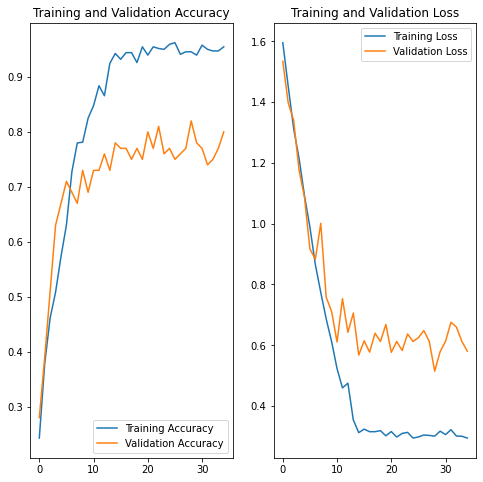

In [29]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model 4:  mobilenet + gru Adam optimizer not training all layers , epoch 20

In [30]:
from keras.applications import mobilenet
import abc
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
import cv2


In [31]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)

    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [32]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs

In [33]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser ='adam' #optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)

    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
#     @abc.abstractmethod
#     def define_model(self):
#         pass

In [34]:
project_folder='datasets/Project_data'
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)              

In [35]:

print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453


/tmp/ipykernel_375/3671313463.py:176: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
/tmp/ipykernel_375/3671313463.py:110: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
/tmp/ipykernel_375/3671313463.py:111: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  image_resized=imresize(image,(self.image_height,self.image_width,3))
/tmp/ipykernel_375/3671313463.py:130: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is dep

Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.2533 - categorical_accuracy: 0.4925
Epoch 00001: saving model to model_init_2022-05-1511_17_24.011494/model-00001-1.25333-0.49246-0.72099-0.73000.h5
133/133 [==============================] - 91s 659ms/step - loss: 1.2533 - categorical_accuracy: 0.4925 - val_loss: 0.7210 - val_categorical_accuracy: 0.7300 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6597 - categorical_accuracy: 0.7715
Epoch 00002: saving model to model_init_2022-05-1511_17_24.011494/model-00002-0.65972-0.77149-0.60658-0.75000.h5
133/133 [==============================] - 91s 691ms/step - loss: 0.6597 - categorical_accuracy: 0.7715 - val_loss: 0.6066 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4412 - categorical_accuracy: 0.8386
Epoch 00003: saving model to model_init_2022-05-1511_17_24.011494/model-00003-0.44116-0.83861-0.59711-0.7900

## Model 5: Mobilenet 2D + GRU(batch size 5, frames to sample 16) Adam optimizer and training weights for all layers epoch 20

In [36]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = 'adam' #optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)

    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


In [37]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, 16, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 16, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 16, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 16, 1024)         0         
 tributed)                                                       
                                                                 
 gru_2 (GRU)                 (None, 128)              

In [38]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253


/tmp/ipykernel_375/971982952.py:174: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
/tmp/ipykernel_375/971982952.py:108: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
/tmp/ipykernel_375/971982952.py:109: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  image_resized=imresize(image,(self.image_height,self.image_width,3))
/tmp/ipykernel_375/971982952.py:128: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is depreca

Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 0.8887 - categorical_accuracy: 0.6493
Epoch 00001: saving model to model_init_2022-05-1511_46_47.948988/model-00001-0.88868-0.64932-0.28528-0.91000.h5
133/133 [==============================] - 94s 682ms/step - loss: 0.8887 - categorical_accuracy: 0.6493 - val_loss: 0.2853 - val_categorical_accuracy: 0.9100 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.3335 - categorical_accuracy: 0.8959
Epoch 00002: saving model to model_init_2022-05-1511_46_47.948988/model-00002-0.33353-0.89593-0.34851-0.87000.h5
133/133 [==============================] - 90s 677ms/step - loss: 0.3335 - categorical_accuracy: 0.8959 - val_loss: 0.3485 - val_categorical_accuracy: 0.8700 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.2506 - categorical_accuracy: 0.9201
Epoch 00003: saving model to model_init_2022-05-1511_46_47.948988/model-00003-0.25055-0.92006-0.33366-0.8600

### Looks like overfitting

## Model 6

### mobilenet 2d+gru(batch size 20, frames to sample 15),epoch 25 optimizer ADAM and training all weights

In [39]:
batch_size = 40 #experiment with the batch size
x = 30
y = 120
z = 120

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    
                    resized_image = imresize(image,(y,z))
                    resized_image = resized_image/255
                         
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = imresize(image,(y,z))
                    resized_image = resized_image/255
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        


In [40]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = tf.keras.optimizers.Adam(0.00001)
        #optimiser = 'adam' #optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=imresize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=imresize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)

    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history


In [41]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=15,batch_size=20,num_epochs=25)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.15)
rnn_cnn_tl2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 15, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 15, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_11 (TimeDi  (None, 15, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 15, 1024)         0         
 stributed)                                                      
                                                                 
 gru_3 (GRU)                 (None, 128)              

In [42]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253


/tmp/ipykernel_375/1420973225.py:174: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1,
/tmp/ipykernel_375/1420973225.py:108: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
/tmp/ipykernel_375/1420973225.py:109: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  image_resized=imresize(image,(self.image_height,self.image_width,3))
/tmp/ipykernel_375/1420973225.py:128: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is dep

Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7230 - categorical_accuracy: 0.2323
Epoch 00001: saving model to model_init_2022-05-1512_21_22.342108/model-00001-1.72297-0.23228-1.75675-0.26000.h5
34/34 [==============================] - 92s 3s/step - loss: 1.7230 - categorical_accuracy: 0.2323 - val_loss: 1.7568 - val_categorical_accuracy: 0.2600 - lr: 1.0000e-05
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.5896 - categorical_accuracy: 0.2798
Epoch 00002: saving model to model_init_2022-05-1512_21_22.342108/model-00002-1.58965-0.27979-1.61517-0.29000.h5
34/34 [==============================] - 84s 3s/step - loss: 1.5896 - categorical_accuracy: 0.2798 - val_loss: 1.6152 - val_categorical_accuracy: 0.2900 - lr: 1.0000e-05
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.5006 - categorical_accuracy: 0.3484
Epoch 00003: saving model to model_init_2022-05-1512_21_22.342108/model-00003-1.50060-0.34842-1.57798-0.30000.h5
34/

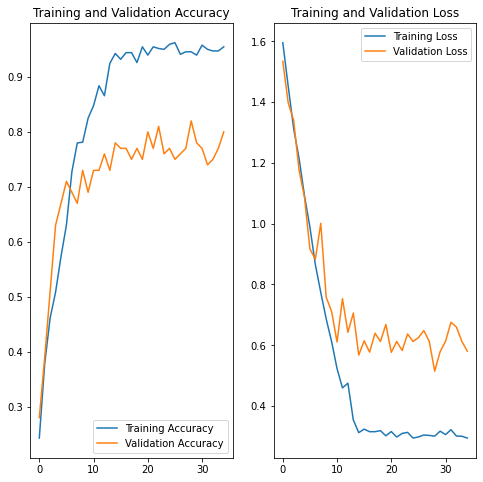

In [44]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Conclusion: 
- <p>This model looks good with validation dataset with <i>validation accuracy</i> of <b>80%</b> and <i>training accuarcy</i> <b>93.97%</b>
- ConvGRU based models have lot more parameters but outperformed when compared to conv3D based models.